# **Data Analysis Interview Challenge with Ultimate, Inc. Data**

The attached "logins.json" file contains (simulated) timestamps of user logins in a particular geographic location. These login counts will be aggregatged based on 15­ minute time intervals, and the resulting time series of login counts will be described and visualized in ways that best characterize the underlying patterns of the demand.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import datetime
import seaborn as sns
import scipy
from google.colab import files
from scipy.stats import randint, loguniform, expon
import time
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.filterwarnings("ignore")
style.use('seaborn-bright')

This project was initiated in Google Colab so a TPU could be utilized for randomized search cross-validation and hyperparameter tuning. Here, we will import the data set.

In [ ]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving logins.json to logins.json


In [ ]:
uploaded_files = files.upload()

Saving ultimate_data_challenge.json to ultimate_data_challenge.json


## **Exploratory Data Analysis**

In [ ]:
# Now, we can read the .json files from desktop
df = pd.read_json('logins.json')
ddf = pd.read_json('ultimate_data_challenge.json')

df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [ ]:
df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


It appears as if this time series begins on 1-1-70 and ends on 4-13-70.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


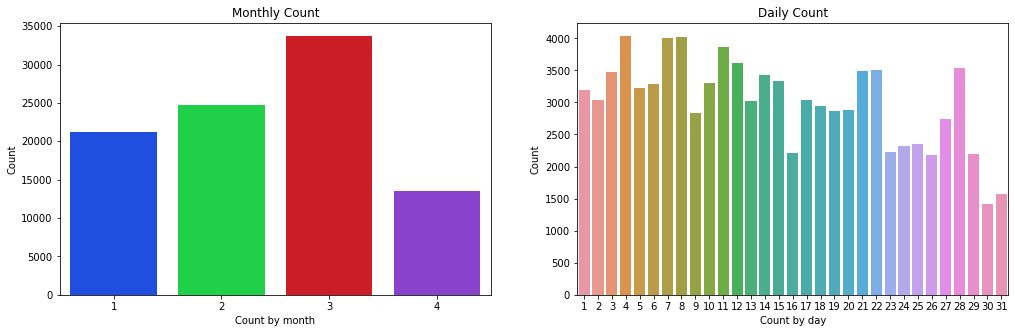

In [ ]:
datetimes = list(map(lambda x: x.date(), df['login_time'].tolist())) 

months = list(map(lambda x: x.month, datetimes)) 
days = list(map(lambda x: x.day, datetimes))

df_datetimes = pd.DataFrame({'month':months, 'day':days}) 


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,5))

df1 = df_datetimes.groupby('month').count()
sns.barplot(x=df1.index.tolist(), y="day", data=df1, ax=ax1);
ax1.set(xlabel='Count by month', ylabel="Count", title="Monthly Count");


df2 = df_datetimes.groupby('day').count()
sns.barplot(x=df2.index.tolist(), y="month", data=df2, ax=ax2);
ax2.set(xlabel='Count by day', ylabel="Count", title="Daily Count");

The trend on logins appears to increase but the data we have for April is incomplete.

In [ ]:
dfx = pd.DataFrame.copy(df)
dfx.set_index('login_time', inplace=True) # set index to be the timestamps, to allow aggregation
dfx['count'] = 1    # each timestamp has 1 count
dfx.sort_index(inplace=True)
df_15 = dfx.resample('15T').sum()   # aggregate by 15-min intervals
df_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


The aggregation of the time series in 15 minute intervals was successful.  There is clearly a pattern here as shown below.

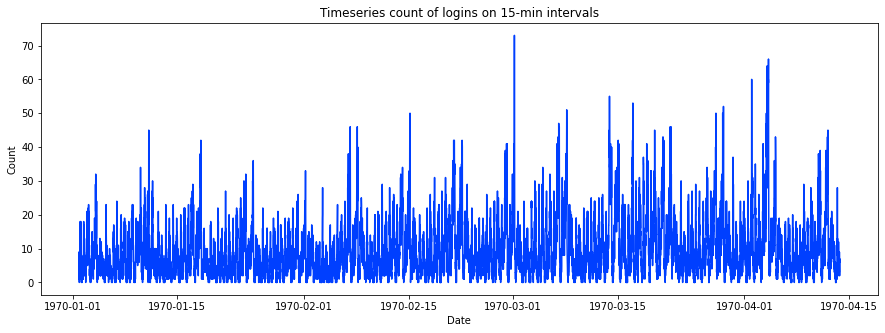

In [ ]:
plt.figure(figsize=(15,5));
plt.plot(df_15);
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Timeseries count of logins on 15-min intervals');

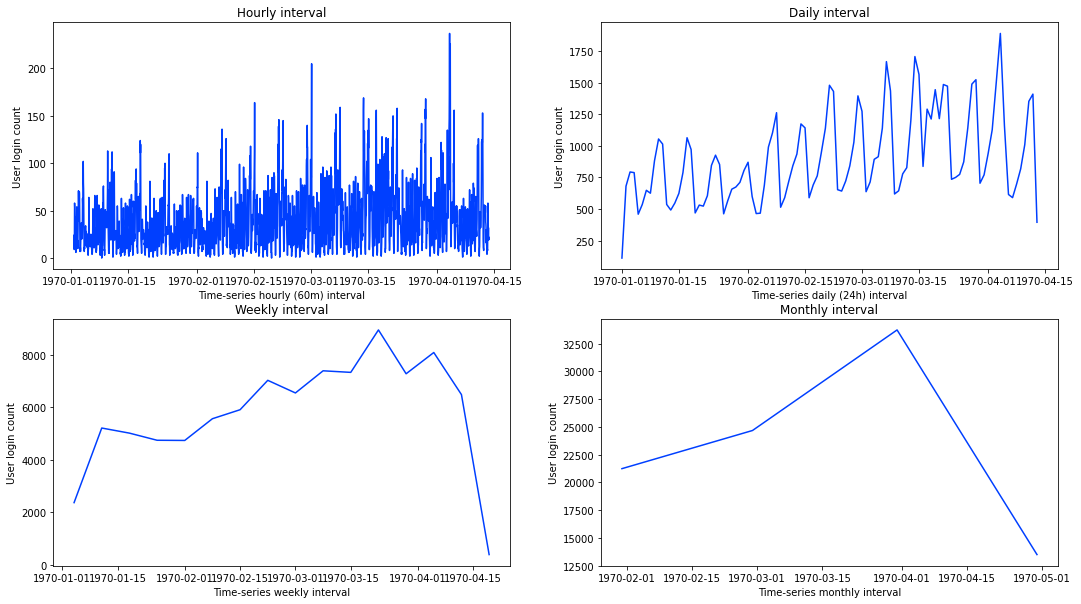

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,10));

# 60-min interval
ax1.plot(dfx.resample('60T').sum());
ax1.set(xlabel='Time-series hourly (60m) interval', ylabel='User login count', title='Hourly interval');

# Daily interval
ax2.plot(dfx.resample('D').sum());
ax2.set(xlabel='Time-series daily (24h) interval', ylabel='User login count', title='Daily interval');

# Weekly interval
ax3.plot(dfx.resample('W').sum());
ax3.set(xlabel='Time-series weekly interval', ylabel='User login count', title='Weekly interval');

# Monthly interval
ax4.plot(dfx.resample('M').sum());
ax4.set(xlabel='Time-series monthly interval', ylabel='User login count', title='Monthly interval');

The daily intervals clearly show that there are peaks and troughs on a daily basis.  We will explore these fluctuations further.  As for the weekly and monthly intervals, there is clearly an upward trend until April. Let's take a look at February as we see that the 1st of February is a Sunday. Logins clearly increase early Sunday (Saturdy night) and again on the following Saturday.

In [ ]:
datetime.datetime(1970, 2, 1).weekday()

6

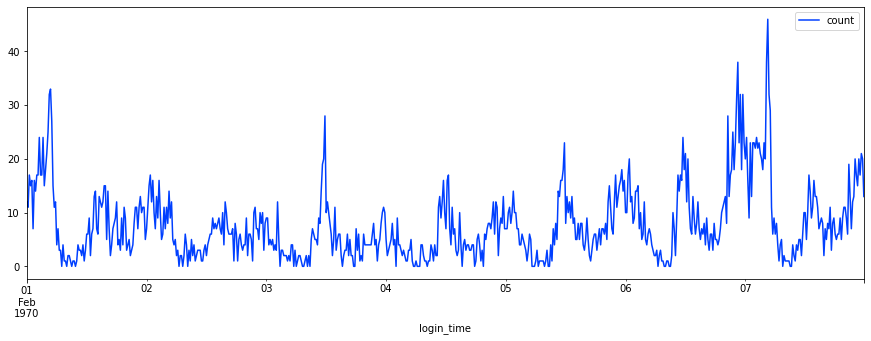

In [ ]:
df_15.loc['1970-02-01':'1970-02-07'].plot(figsize=(15,5))
plt.show()

The rolling mean clearly shows the increase in activity on the weekend.

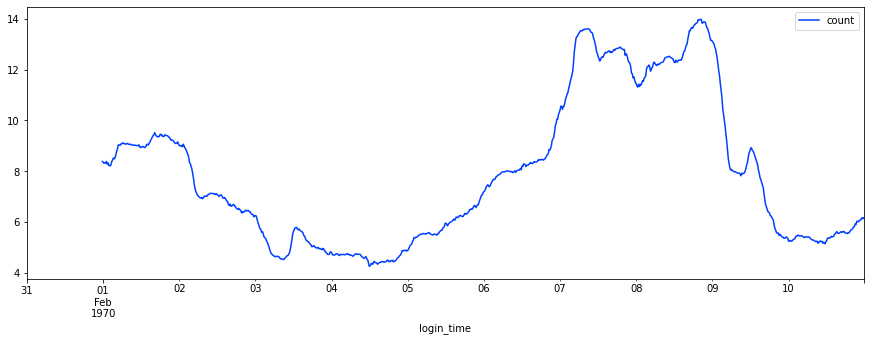

In [ ]:
df_15.loc['1970-01-31':'1970-02-10'].rolling(window=96).mean().plot(figsize=(15,5))
plt.show()

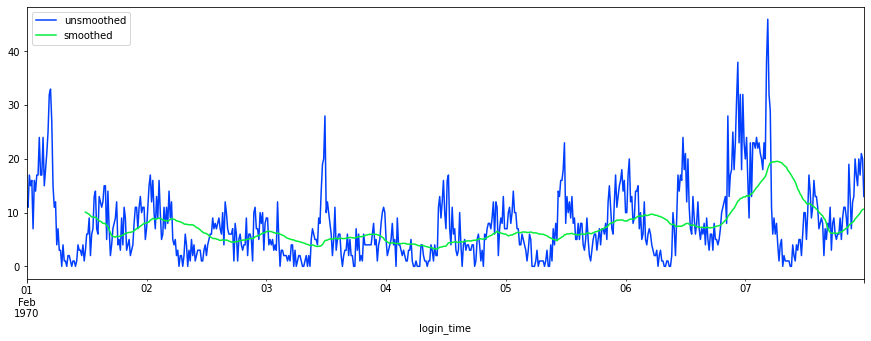

In [ ]:
unsmoothed = df_15['count']['1970-02-01':'1970-02-07']
smoothed = unsmoothed.rolling(window=48).mean()
one_week = pd.DataFrame({'unsmoothed':unsmoothed, 'smoothed':smoothed})
one_week.plot(figsize=(15,5))
plt.show()

As we take a snapshot of the weekend, we see that there is increased activity around noon on Friday but a marked increase after midnight on Friday and Saturday night indicating riders probably need a ride home after closing down bars or needing rides to the airport for early flights.

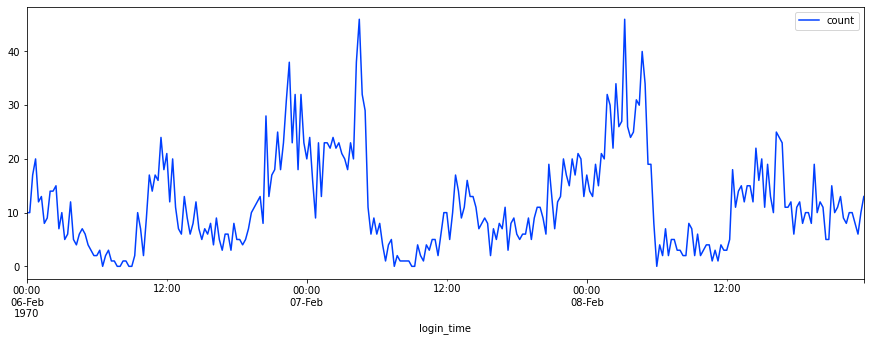

In [ ]:
df_15.loc['1970-02-06':'1970-02-08'].plot(figsize=(15,5))
plt.show()

During the week on a Wednesday and Thursday, we can see that activity increases at noon but also again in the evening hours.  

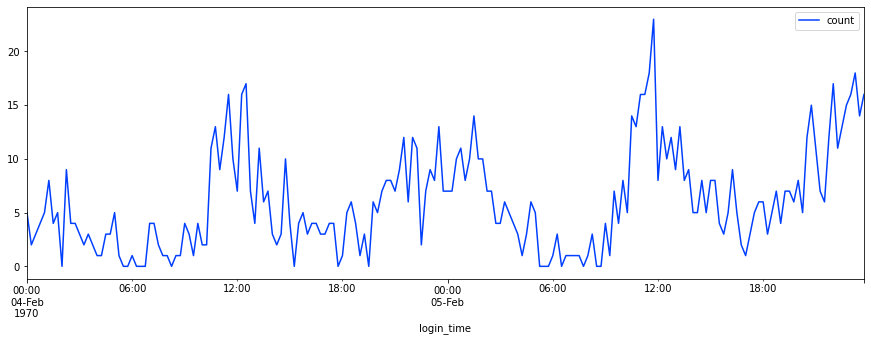

In [ ]:
df_15.loc['1970-02-04':'1970-02-05'].plot(figsize=(15,5))
plt.show()

To be fair, we will take a look at January and we see that New Year's Day is on a Thursday.  We want to avoid New Year's as the activity is not typical.  We take a look at the following Wednesday and Thursday. It is roughly the same activity as above with spikes at noon and midnight.

In [ ]:
date = datetime.datetime(1970, 1, 1)
date.weekday()

3

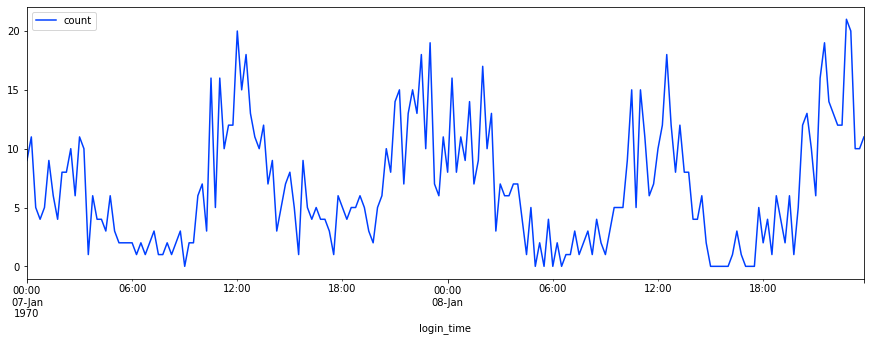

In [ ]:
df_15.loc['1970-01-07':'1970-01-08' ].plot(figsize=(15,5))
plt.show()

## **Predictive Modeling**

In [ ]:
display(ddf.shape)
display(ddf.info())
display(ddf.columns)

(50000, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


None

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [ ]:
ddf.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [ ]:
ddf.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


To summarize this data, there appears to be 50,000 observations and 12 features.  There does not seem to be any glaring data issues but we will analyze further.  Initially, the date colums are set as objects and they will need converted to datetime data types.  

In [ ]:
ddf.last_trip_date = pd.to_datetime(ddf.last_trip_date)
ddf.signup_date = pd.to_datetime(ddf.signup_date)

In [ ]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [ ]:
ddf['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

### **Feature Engineering**

It appears that this data runs from 1-1-2014 to 7-1-2014 and we will use the last trip date to determine the percentage of riders that were retained in the last 30 days and to create our target variable - 'retained.'

In [ ]:
fraction_retained = (ddf.last_trip_date >= '2014-06-01').sum() / (ddf.last_trip_date >= '2014-06-01').count()
fraction_retained

0.37608

In [ ]:
ddf['retained'] = (ddf.last_trip_date >= '2014-06-01')*1

About 37.6% of riders have been retained.  This column was converted to numeric to prepare for modeling.  

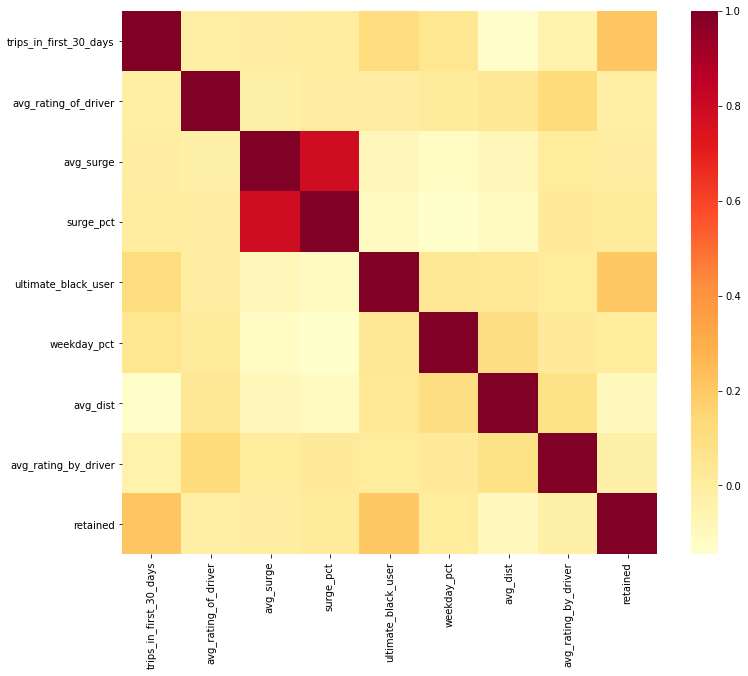

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
corr = ddf.corr()
ax = sns.heatmap(corr, cmap = 'YlOrRd')
plt.show()

This heatmap shows that there are no strong correlations with the target but trips in the first 30 days and riders that use ultimate black are the most correlated.  There is one issue as average surge and surge percent are highly correlated which makes sense.  One of these colums will be removed before training.

In [ ]:
#drop rows with no phone information, since we cannot infer that without building a predictive model
ddf = ddf.drop(ddf[ddf.phone.isna()==True].index,axis=0)
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    41578 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49406 non-null  float64       
 12  retained                49604 non-null  int64 

The cities and phones variables are categorical.  They do not contain many different values however, so utilizing one-hot encoding would not drastically increase the number of features.  These new features will be added 'city' and 'phone' will be dropped from the data set.

In [ ]:
cities_hot = pd.get_dummies(ddf['city'])
phones_hot = pd.get_dummies(ddf['phone'])

In [ ]:
ddf = ddf.join(cities_hot).join(phones_hot)

In [ ]:
ddf.drop(['city', 'phone'], axis=1, inplace=True)

The 'retained' column will be moved back to the end.

In [ ]:
# move 'retained' to the end
col_at_end = ['retained']
ddf = ddf[[c for c in ddf if c not in col_at_end]
       + [c for c in col_at_end if c in ddf]]

In [ ]:
ddf.describe().iloc[:, -6:-1]

,Astapor,King's Landing,Winterfell,Android,iPhone
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,0.330881,0.202927,0.466192,0.302838,0.697162
std,0.470535,0.402183,0.498861,0.459491,0.459491
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


This data looks relatively normal.  Now, the sign up date column will be converted to numeric as well as the ultimate black user column.

In [ ]:
ddf['signup_date'] = ddf['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100

In [ ]:
ddf['ultimate_black_user'] = ddf['ultimate_black_user']*1

In [ ]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  49604 non-null  int64         
 1   signup_date             49604 non-null  int64         
 2   avg_rating_of_driver    41578 non-null  float64       
 3   avg_surge               49604 non-null  float64       
 4   last_trip_date          49604 non-null  datetime64[ns]
 5   surge_pct               49604 non-null  float64       
 6   ultimate_black_user     49604 non-null  int64         
 7   weekday_pct             49604 non-null  float64       
 8   avg_dist                49604 non-null  float64       
 9   avg_rating_by_driver    49406 non-null  float64       
 10  Astapor                 49604 non-null  uint8         
 11  King's Landing          49604 non-null  uint8         
 12  Winterfell              49604 non-null  uint8 

All of the data is ready for modeling except for the last trip date which will be dropped since it was used to create the target variable.  Let's take one last look at the data with a series of histograms.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e502b3190>,
      dtype=object)

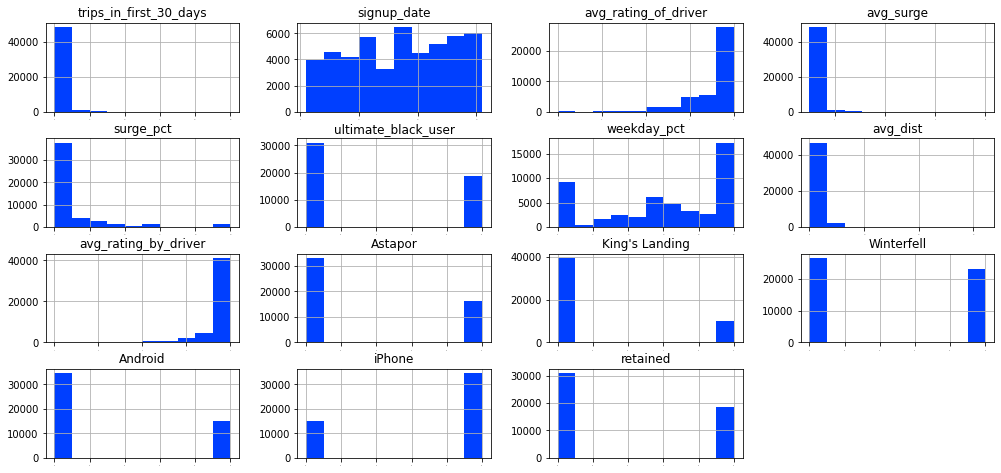

In [ ]:
ddf.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(17,8))

Most of this data is not normally distributed so we will use MinMax Scaler to scale the data.  The surge percentage column will be dropped as it is strongly correlated with average surge and has a high variance.  Normalization was not performed because linear classifiers could not compute the data set with normalized columns.  A support vector machine took two hours to complete and logistic regression would not run.  The support vector machine was not used in this project.

In [ ]:
np.random.seed(2346)


features = [column for column in ddf.columns.tolist() if
                    column not in ['last_trip_date', 'retained', 'surge_pct']]

transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer, features)]
)

In [ ]:
X = ddf.drop(['retained', 'last_trip_date', 'surge_pct'], axis=1)
y = ddf['retained']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2346, stratify=y)

In [ ]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'AUC', 'Time to Train'], 
                       columns=['Logistic Regression', 'K Nearest Neighbors', 'Random Forest', 'AdaBoost', 'XGBoost'])

In [ ]:
def train_and_score_model(model_name, estimator, param_grid=None, cv=5):
    
    
    if model_name == 'Logistic Regression':
        cv = GridSearchCV(estimator, param_grid, cv=cv)
    elif model_name == 'XGBoost': 
        cv = RandomizedSearchCV(estimator, param_distributions = param_grid, cv = cv)
    else:
        cv = RandomizedSearchCV(estimator, param_grid, cv=cv, random_state=None)
    
    
    
    t0 = time.time()
    cv.fit(X_train, y_train)
    ttt = time.time() - t0 # ttt stands for "time to train"
    print("It takes %.3f seconds for %s fitting" % (ttt, model_name))
    metrics.loc['Time to Train', model_name] = ttt


    y_pred = cv.predict(X_test)


    print("Accuracy with " + model_name + " on the testing set is: %.3f" % cv.score(X_test, y_test))

    metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
    
    
    y_pred_prob = cv.predict_proba(X_test)[:,1]
    metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred_prob)

    
    print(classification_report(y_test, y_pred))

    
    fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s ROC Curve' % model_name)
    plt.show()

    return cv

In [ ]:
#Instantiate the model/estimator

classifier_lr = LogisticRegression(solver='liblinear', random_state=2346)
classifier_knn = KNeighborsClassifier()
classifier_rf = RandomForestClassifier(random_state=2346)
classifier_ada = AdaBoostClassifier(random_state=2346)
classifier_xgb = xgb.XGBClassifier(objective = 'binary:logistic', seed=2346, scoring = "neg_mean_squared_error", n_iter = 5, verbose=1)

classifiers = [classifier_lr, classifier_knn, classifier_rf, classifier_ada, classifier_xgb]

#Specify the Hyperparameter Space

param_grid_lr = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': np.logspace(-5, 8, 15),
    'classifier__penalty': ['l1', 'l2']
}
param_grid_knn = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_neighbors': np.arange(1,20),
    'classifier__leaf_size':np.arange(20,100)
}

param_grid_rf = {
                 'preprocessor__num__imputer__strategy': ['mean', 'median'], 
                 'classifier__n_estimators': np.arange(100,500),
                 'classifier__criterion': ["gini", "entropy"],
                 'classifier__max_depth': np.arange(3,20),
                 'classifier__min_samples_leaf': randint(1, 9),
                 'classifier__min_samples_split': randint(2, 9),
                 'classifier__max_features': randint(1, 9)
}

param_grid_ada = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_estimators': np.arange(100,500),
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]
}

param_grid_xgb = {
                 'classifier__max_depth': np.arange(2, 20),
                 'classifier__n_estimators': np.arange(100,500),
                 'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
                 'classifier__subsample': np.arange(0.5, 1.0),
                 'classifier__colsample_bytree': np.arange(0.4, 1.0),
                 'classifier__colsample_bylevel': np.arange(0.4, 1.0),
                 'classifier__min_child_weight': np.arange(1, 10),
                 'classifier__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0] 
}

param_grids = [param_grid_lr, param_grid_knn, param_grid_rf, param_grid_ada, param_grid_xgb]

model_names = ['Logistic Regression', 'K Nearest Neighbors', 'Random Forest', 'AdaBoost', 'XGBoost']
cv_names = ['lr_cv', 'knn_cv', 'rf_cv', 'ada_cv', 'xgb_cv']
cvs = [5, 5, 5, 5, 5]

It takes 65.262 seconds for Logistic Regression fitting
Accuracy with Logistic Regression on the testing set is: 0.720
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      9280
           1       0.67      0.50      0.57      5602

    accuracy                           0.72     14882
   macro avg       0.70      0.68      0.68     14882
weighted avg       0.71      0.72      0.71     14882



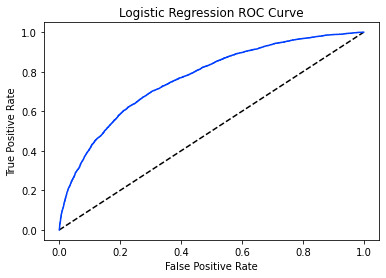

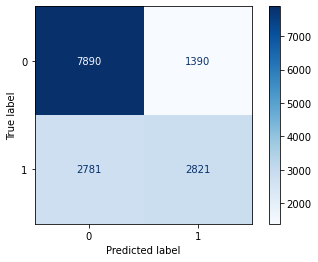

It takes 74.804 seconds for K Nearest Neighbors fitting
Accuracy with K Nearest Neighbors on the testing set is: 0.755
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      9280
           1       0.70      0.60      0.65      5602

    accuracy                           0.76     14882
   macro avg       0.74      0.72      0.73     14882
weighted avg       0.75      0.76      0.75     14882



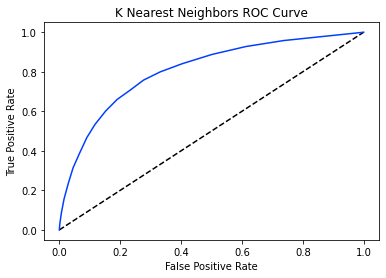

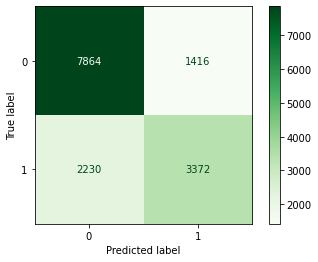

It takes 346.542 seconds for Random Forest fitting
Accuracy with Random Forest on the testing set is: 0.779
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9280
           1       0.73      0.65      0.69      5602

    accuracy                           0.78     14882
   macro avg       0.77      0.75      0.76     14882
weighted avg       0.78      0.78      0.78     14882



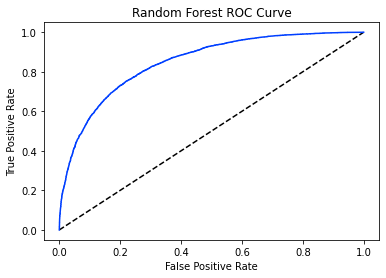

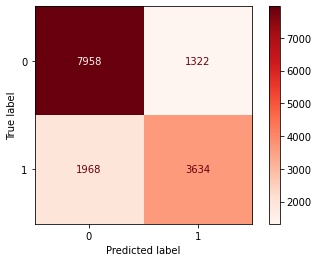

It takes 256.012 seconds for AdaBoost fitting
Accuracy with AdaBoost on the testing set is: 0.780
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9280
           1       0.73      0.65      0.69      5602

    accuracy                           0.78     14882
   macro avg       0.77      0.75      0.76     14882
weighted avg       0.78      0.78      0.78     14882



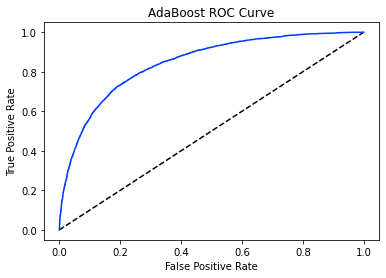

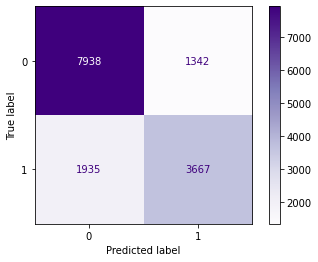

It takes 260.742 seconds for XGBoost fitting
Accuracy with XGBoost on the testing set is: 0.787
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      9280
           1       0.74      0.67      0.70      5602

    accuracy                           0.79     14882
   macro avg       0.78      0.76      0.77     14882
weighted avg       0.78      0.79      0.78     14882



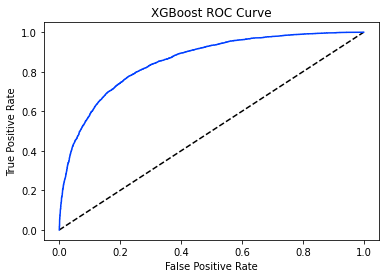

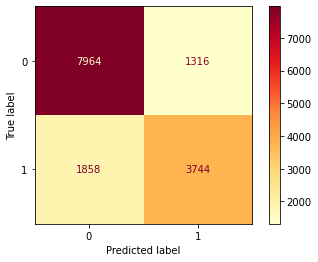

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_lr)])
lr_cv = train_and_score_model('Logistic Regression', pipeline, param_grid_lr)

plot_confusion_matrix(lr_cv, X_test, y_test, cmap = 'Blues', values_format = '')
plt.grid(False)
plt.show()
    
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_knn)])

knn_cv = train_and_score_model('K Nearest Neighbors', pipeline, param_grid_knn)

plot_confusion_matrix(knn_cv, X_test, y_test, cmap = 'Greens', values_format = '')
plt.grid(False)
plt.show()
    
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_rf)])

rf_cv = train_and_score_model('Random Forest', pipeline, param_grid_rf)

plot_confusion_matrix(rf_cv, X_test, y_test, cmap = 'Reds', values_format = '')
plt.grid(False)
plt.show()

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_ada)])

ada_cv = train_and_score_model('AdaBoost', pipeline, param_grid_ada)

plot_confusion_matrix(ada_cv, X_test, y_test, cmap = 'Purples', values_format = '')
plt.grid(False)
plt.show()

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_xgb)])
xgb_cv = train_and_score_model('XGBoost', pipeline, param_grid_xgb)

plot_confusion_matrix(xgb_cv, X_test, y_test, cmap = 'YlOrRd', values_format = '')
plt.grid(False)
plt.show()

In [ ]:
from pandas.plotting import table
metrics.astype(float).round(3)
model_metrics = metrics.astype(float).round(3).loc[['accuracy', 'precision', 'recall', 'AUC']]*100
model_metrics

,Logistic Regression,K Nearest Neighbors,Random Forest,AdaBoost,XGBoost
accuracy,72.0,75.5,77.9,78.0,78.7
precision,67.0,70.4,73.3,73.2,74.0
recall,50.4,60.2,64.9,65.5,66.8
AUC,76.6,80.7,84.8,84.5,85.5


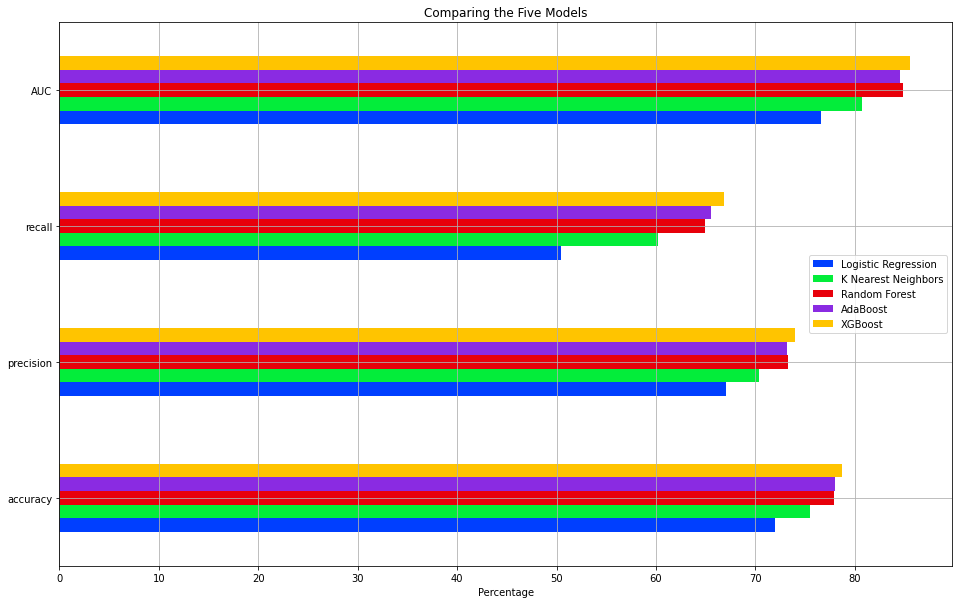

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
model_metrics.plot(kind='barh', ax=ax)
ax.set_xlabel('Percentage')
ax.set_title('Comparing the Five Models')
ax.grid();

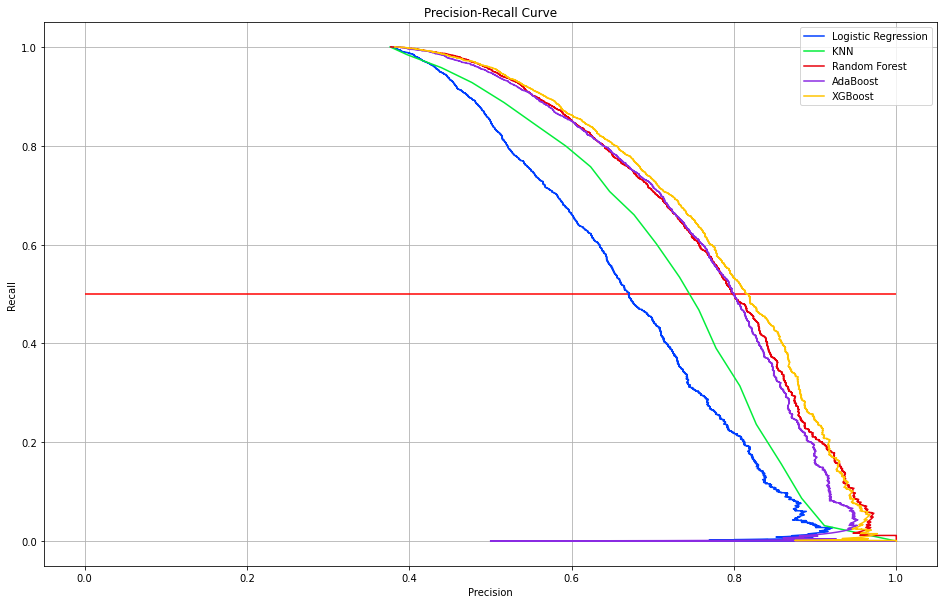

In [ ]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, probas_pred=lr_cv.predict_proba(X_test)[:,1])
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_true=y_test, probas_pred=knn_cv.predict_proba(X_test)[:,1])
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_true=y_test, probas_pred=rf_cv.predict_proba(X_test)[:,1])
precision_ada, recall_ada, thresholds_ada = precision_recall_curve(y_true=y_test, probas_pred=ada_cv.predict_proba(X_test)[:,1])
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_true=y_test, probas_pred=xgb_cv.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(precision_lr, recall_lr, label='Logistic Regression')
ax.plot(precision_knn, recall_knn, label='KNN')
ax.plot(precision_rf, recall_rf, label='Random Forest')
ax.plot(precision_ada, recall_ada, label='AdaBoost')
ax.plot(precision_xgb, recall_xgb, label='XGBoost')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

In [ ]:
xgb_cv.best_params_

{'classifier__colsample_bylevel': 0.4,
 'classifier__colsample_bytree': 0.4,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 6,
 'classifier__min_child_weight': 6,
 'classifier__n_estimators': 261,
 'classifier__reg_lambda': 1.0,
 'classifier__subsample': 0.5}

In [ ]:
# Imputation
ddf.avg_rating_by_driver.fillna(ddf.avg_rating_by_driver.mean(),inplace=True)
ddf.avg_rating_of_driver.fillna(ddf.avg_rating_of_driver.mean(),inplace=True)

In [ ]:
X = ddf.drop(['retained', 'last_trip_date', 'surge_pct'], axis=1)
y = ddf['retained']

X_temp, X_test, y_temp, y_test  =\
    train_test_split(X, y, test_size=0.20, random_state=1111)

X_train, X_val, y_train, y_val =\
    train_test_split(X_temp, y_temp, test_size=0.25, random_state=1111)

In [ ]:
XGB_classifier = XGBClassifier(random_state=1111, max_depth=6, learning_rate = 0.1, min_child_weight = 6, subsample = 0.5,
                                       colsample_bylevel = 0.4, colsample_bytree = 0.4, reg_lambda = 1.0, n_estimators=261)

It takes 4.041 seconds for Extreme Gradient Boost (XGBoost) fitting
Accuracy with Extreme Gradient Boost on the testing set is: 0.786
ROC AUC score is: 0.851
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      6176
           1       0.74      0.66      0.70      3745

    accuracy                           0.79      9921
   macro avg       0.78      0.76      0.77      9921
weighted avg       0.78      0.79      0.78      9921



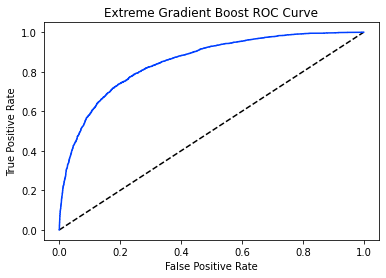

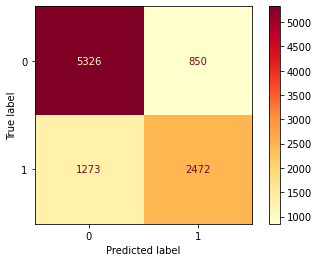

In [ ]:
t0 = time.time()
XGB_classifier.fit(X_train, y_train)
ttt = time.time() - t0 
print("It takes %.3f seconds for %s fitting" % (ttt, 'Extreme Gradient Boost (XGBoost)'))


y_pred = XGB_classifier.predict(X_test)

print("Accuracy with " + 'Extreme Gradient Boost' + " on the testing set is: %.3f" % XGB_classifier.score(X_test, y_test))
    
y_pred_prob = XGB_classifier.predict_proba(X_test)[:,1]
print("ROC AUC score is: %.3f" %roc_auc_score(y_test, y_pred_prob))

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Extreme Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'Extreme Gradient Boost')
plt.show()

plot_confusion_matrix(XGB_classifier, X_test, y_test, cmap = 'YlOrRd', values_format = '')
plt.grid(False)
plt.show()

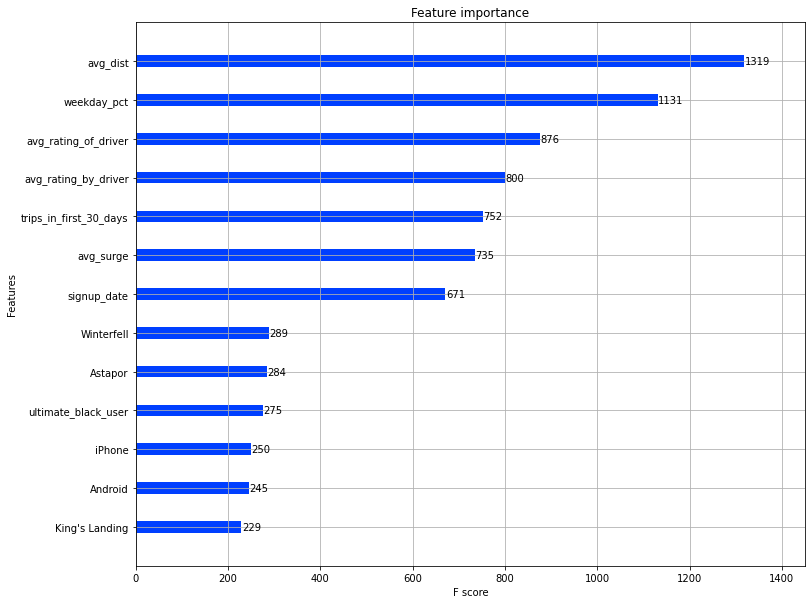

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(XGB_classifier, height=0.3, ax=ax)
plt.show()

In [ ]:
rf_cv.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 16,
 'classifier__max_features': 6,
 'classifier__min_samples_leaf': 8,
 'classifier__min_samples_split': 3,
 'classifier__n_estimators': 213,
 'preprocessor__num__imputer__strategy': 'mean'}

In [ ]:
rf_classifier = RandomForestClassifier(random_state=1111, criterion='entropy', max_depth=16, 
                                       max_features=6, min_samples_leaf=8, min_samples_split=3, n_estimators=213)

It takes 9.778 seconds for Random Forest fitting
Accuracy with Random Forest on the testing set is: 0.778
ROC AUC score is: 0.845
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      6176
           1       0.73      0.65      0.69      3745

    accuracy                           0.78      9921
   macro avg       0.77      0.75      0.76      9921
weighted avg       0.78      0.78      0.78      9921



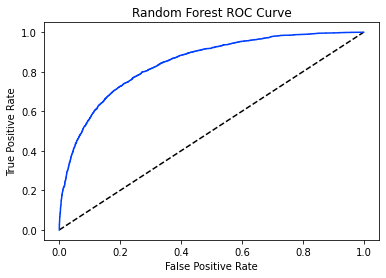

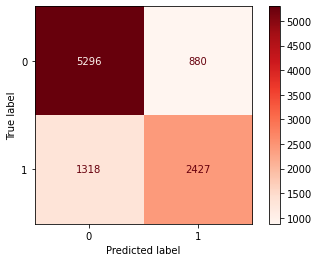

In [ ]:
t0 = time.time()
rf_classifier.fit(X_train, y_train)
ttt = time.time() - t0
print("It takes %.3f seconds for %s fitting" % (ttt, 'Random Forest'))

y_pred = rf_classifier.predict(X_test)

print("Accuracy with " + 'Random Forest' + " on the testing set is: %.3f" % rf_classifier.score(X_test, y_test))
    
y_pred_prob = rf_classifier.predict_proba(X_test)[:,1]
print("ROC AUC score is: %.3f" %roc_auc_score(y_test, y_pred_prob))

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'Random Forest')
plt.show()

plot_confusion_matrix(rf_classifier, X_test, y_test, cmap = 'Reds', values_format = '')
plt.grid(False)
plt.show()

In [ ]:
ada_cv.best_params_

{'classifier__learning_rate': 0.2,
 'classifier__n_estimators': 431,
 'preprocessor__num__imputer__strategy': 'mean'}

In [ ]:
AdaBoost_classifier = AdaBoostClassifier(random_state=1111, n_estimators = 431, learning_rate = 0.2)

It takes 7.697 seconds for AdaBoost fitting
Accuracy with AdaBoost on the testing set is: 0.775
ROC AUC score is: 0.843
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      6176
           1       0.73      0.64      0.68      3745

    accuracy                           0.78      9921
   macro avg       0.76      0.75      0.75      9921
weighted avg       0.77      0.78      0.77      9921



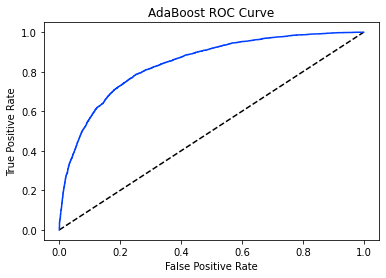

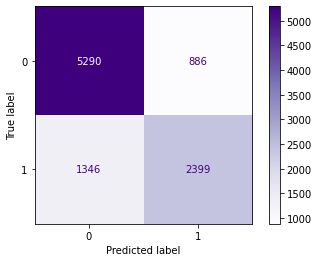

In [ ]:
t0 = time.time()
AdaBoost_classifier.fit(X_train, y_train)
ttt = time.time() - t0
print("It takes %.3f seconds for %s fitting" % (ttt, 'AdaBoost'))

y_pred = AdaBoost_classifier.predict(X_test)

print("Accuracy with " + 'AdaBoost' + " on the testing set is: %.3f" % AdaBoost_classifier.score(X_test, y_test))
    
y_pred_prob = AdaBoost_classifier.predict_proba(X_test)[:,1]
print("ROC AUC score is: %.3f" %roc_auc_score(y_test, y_pred_prob))

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='AdaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'AdaBoost')
plt.show()

plot_confusion_matrix(AdaBoost_classifier, X_test, y_test, cmap = 'Purples', values_format = '')
plt.grid(False)
plt.show()

In [ ]:
def plot_feature_importance(importance, names, model_type):

#Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

#Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

#Define size of bar plot
  plt.figure(figsize=(10,8))
#Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
  plt.title(model_type + ' Feature Importance')
  plt.xlabel('Feature Importance to Model')
  plt.ylabel('Features')

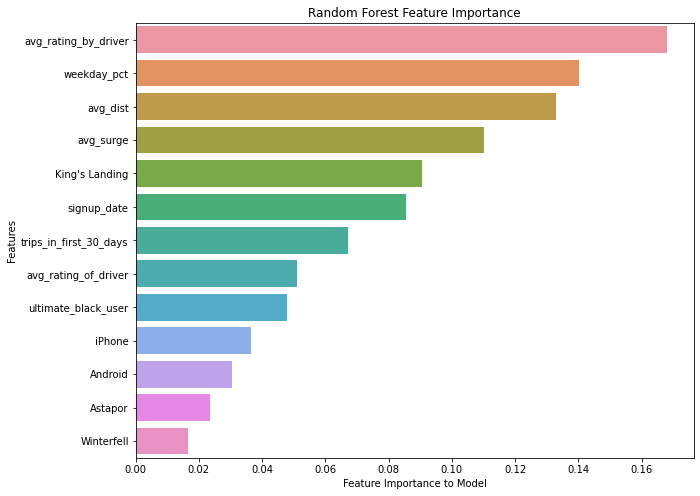

In [ ]:
plot_feature_importance(rf_classifier.feature_importances_, X_train.columns,'Random Forest')

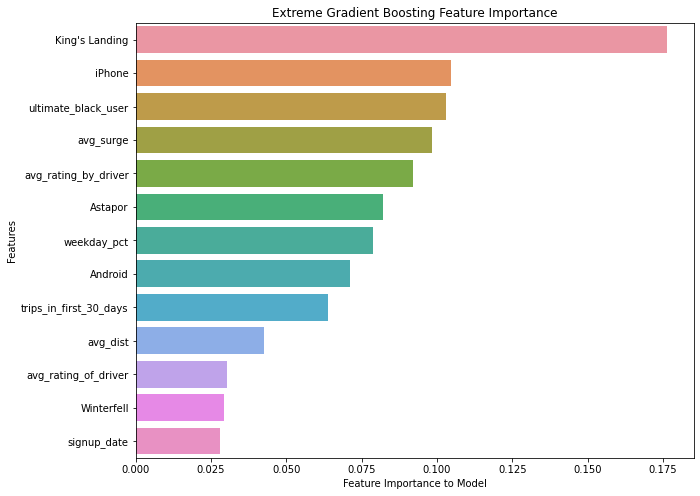

In [ ]:
plot_feature_importance(XGB_classifier.feature_importances_, X_train.columns, 'Extreme Gradient Boosting')

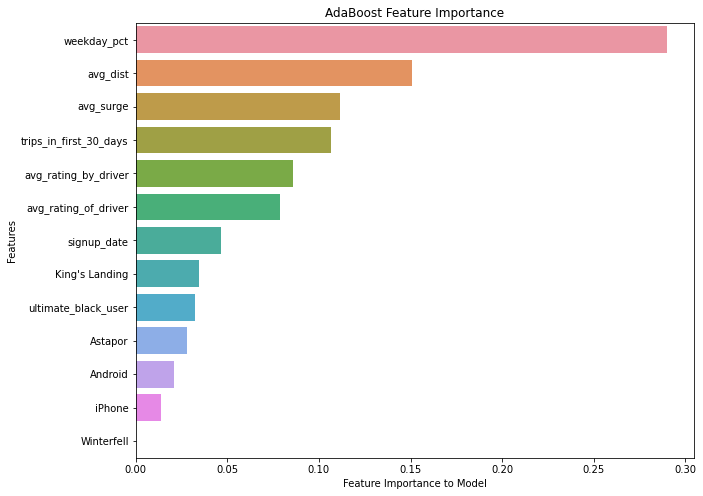

In [ ]:
plot_feature_importance(AdaBoost_classifier.feature_importances_, X_train.columns,'AdaBoost')

In [ ]:
rf_features = rf_classifier.feature_importances_
ada_features = AdaBoost_classifier.feature_importances_
xgb_features = XGB_classifier.feature_importances_

In [ ]:
cols = X.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
      'AdaBoost feature importances': ada_features,
      'Extreme Gradient Boosting feature importances': xgb_features
    })

<Figure size 432x288 with 0 Axes>

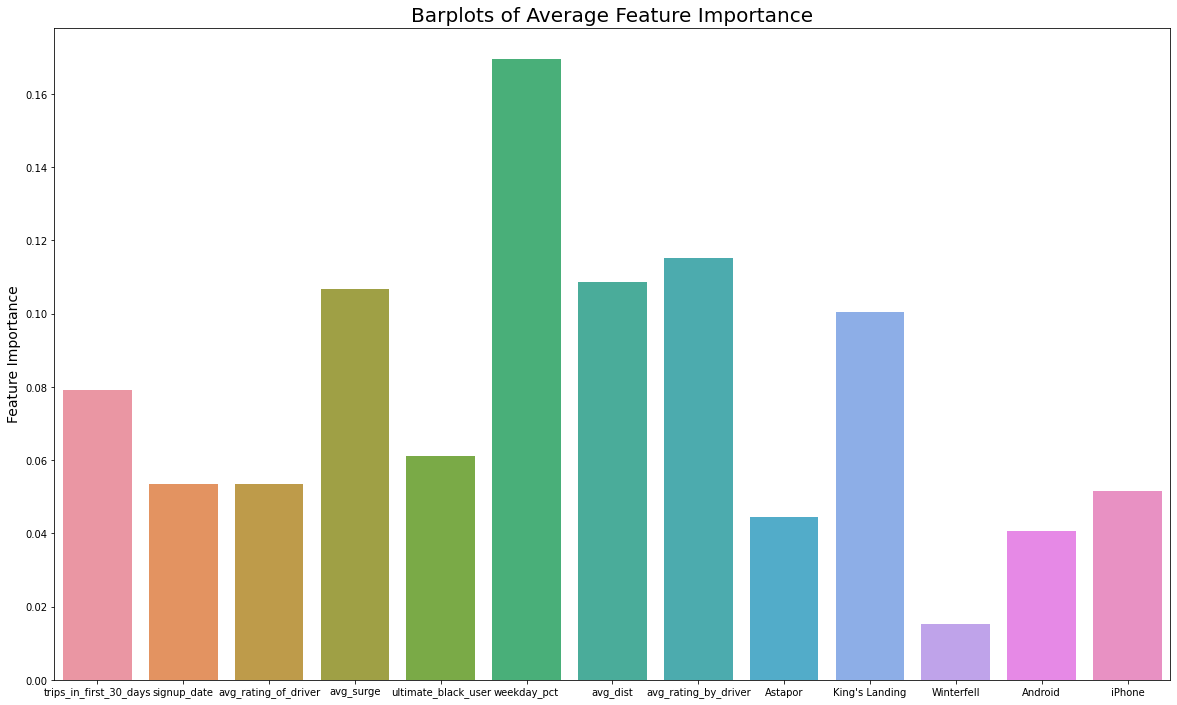

In [ ]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)

yy = feature_dataframe['mean'].values
xx = feature_dataframe['features'].values

plt.figure(facecolor="white")
fig = plt.figure(figsize=(20,12))
sns.barplot(y=yy, x=xx)
plt.title('Barplots of Average Feature Importance', size = 20)
plt.ylabel('Feature Importance', size=14)
plt.show()

While these results are good, it is clear that XGBoost produces the best results.  There are still more hyperparameters to try so let's see if we can increase the accuracy.

In [ ]:
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'max_depth': [6,8,10],
    'min_child_weight':[1,4,6],
    'subsample':[1,0.8,0.5],
    }

In [ ]:
new_xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 1111, learning_rate = 0.1, n_estimators=10)

grid_search = GridSearchCV(param_grid= parameters, estimator = new_xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=10, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1111, reg_alpha=0,
                                     reg_lambda=1, scale_...
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': [1, 2, 3], 'learning_rate': [0.25, 0.2, 0.1],
                         'max_delta_step': [0, 0.05], 'max_depth': [

In [ ]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 1, 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 6, 'scale_pos_weight': 0.95, 'subsample': 1}
0.7813319884344385


This is slightly better providing a beacon of hope.  Now, we will add these best parameters to the rest to see what kind of accuracy we can produce.

In [ ]:
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 1111,
                        'silent': 0,
                        'subsample': 1, 
                        'scale_pos_weight': 0.95, 
                        'min_child_weight': 6, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.2, 
                        'gamma': 3,
                       }

In [ ]:
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3,
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=6, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.95, seed=None,
              silent=0, subsample=1, verbosity=1)

Accuracy with the new XGBoost classifier on the testing set is: 0.802.
ROC AUC score is: 0.846
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      6176
           1       0.73      0.64      0.68      3745

    accuracy                           0.78      9921
   macro avg       0.76      0.75      0.75      9921
weighted avg       0.77      0.78      0.77      9921



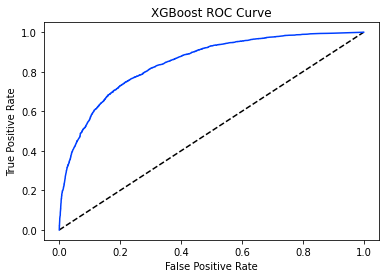

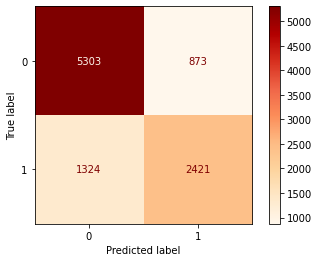

In [ ]:
y_opt_pred = xg_clf_opt.predict(X_train)

score = accuracy_score(y_train, y_opt_pred)

print("Accuracy with " + 'the new XGBoost classifier' + " on the testing set is: {}.".format(round(score,3)))
    
y_pred_prob = xg_clf_opt.predict_proba(X_test)[:,1]
print("ROC AUC score is: %.3f" %roc_auc_score(y_test, y_pred_prob))

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='New XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'XGBoost')
plt.show()

plot_confusion_matrix(xg_clf_opt, X_test, y_test, cmap = 'OrRd', values_format = '')
plt.grid(False)
plt.show()

## **Conclusion**

The optimized XGBoost model produced over an 80% accuracy providing a model suitable of determining the likelihood of retaining riders for Ultimate. It is worth noting that the initial XGBoost Model produced and area under the ROC curve of 0.855 which is almost 1 percent more than the optimized model. Different models produced vastly different feature importances but these importances were averaged acros the most accurate models to provide a final ranking.  